## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 2


In [4]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{c['livetime']}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz


## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    
       
    return dataset_asimov_N, dataset_asimov

In [6]:
datasets_N = []
datasets = []
for n in range(len(livetimes)):
    dataset_asimov_N, dataset_asimov = set_up(dataset_input)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

In [7]:
print("read")
for i, d in enumerate(datasets):
    print(i)
    path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
    datasets[i].models = Models.read(path)
for i, d in enumerate(datasets_N):
    try:
        print(i)
        path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
        print(path)
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
        datasets_N[i].models.parameters['tilt'].frozen = False 
    except:
        print("no", i)


read
0
1
2
3
4
5
6
7
8
9
10
11
12
0
../Eff_area_PKSflare_crab_cutoff/data/0_model_nui_livetime_0.01.yml
models_load Models

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.302   +/-    1.27             
    amplitude                     :   3.86e-11   +/- 3.7e-11 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.100   +/-    0.55 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.03 deg         
    lat_0                         :    -30.222   +/-    0.03 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset_N-bkg
  Datasets names            : ['dataset_N']

## RND Fluxpoints

In [8]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 100
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]
flux = np.loadtxt(f"../{c['folder']}/data/1_P_draw_flux.txt")
flux2e = np.loadtxt(f"../{c['folder']}/data/1_P_draw_flux2e.txt")
flux_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_flux.txt")
flux_N2e = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_flux2e.txt")



pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
lives = pars_N[:N_max, -1:]

In [9]:
fpd_Ns, fpd_s = [], []

s = 0.
t = 0.
r = 0.
b = 0.
rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
for i in range((1)):
    l = c['livetime']
    try:
        fluxpoints = FluxPoints.read(
            f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_{l}_{rnds}.fits"
        )
        fluxpoints_N = FluxPoints.read(
            f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_N_{l}_{rnds}.fits"
        )
        model_name = f"../{c['folder']}/data/fluxpoints/1P_model_N_{l}_{rnds}.yaml"
        fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
        model_name = f"../{c['folder']}/data/fluxpoints/1P_model_{l}_{rnds}.yaml"
        fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
        fpd_Ns.append(fluxpoints_Nds)
        fpd_s.append(fluxpoints_ds)
        print(l)
        
    except:
        j = 0 
    

2.154434690031884


In [10]:
lives = [livetimes]

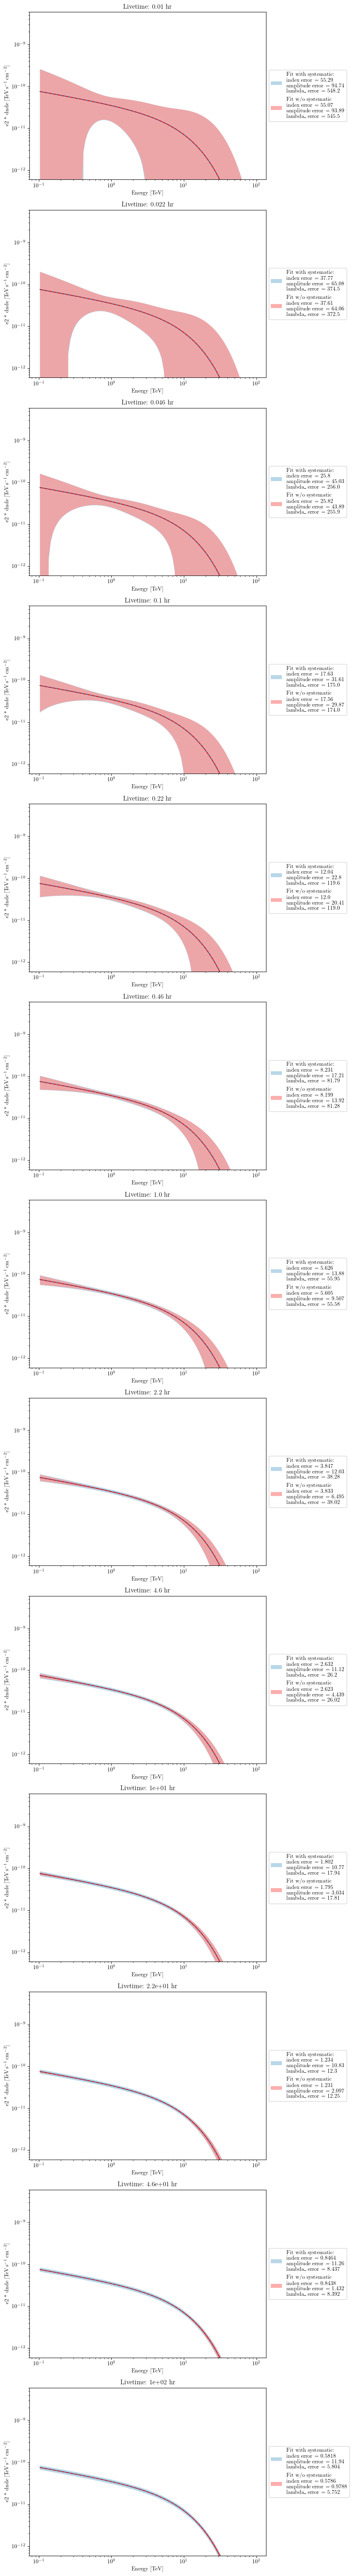

In [11]:
def plot_spectra():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (9, 5 * len(datasets)))
    axs= axs.flatten()
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]

        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)    
        paris = [p.name for p in dataset_N.models[0].spectral_model.parameters.free_parameters]
        def info(dataset):
            info = ""
            for p in paris:
                par = dataset.models[0].parameters[p]
                per = par.error /par.value
                info += f"\n{p} error = {per*100:.4} %"
            return info
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'Fit with systematic: {info(dataset_N)}')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
       
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'Fit w/o systematic{info(dataset)}')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <20:
            ax.set_ylim(6e-13, 6e-9)
            
        
        if live in lives:
            idx = np.where(live == lives)[0][0]
            print(idx)
            fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                                 label = "Fluxpoint with systematic \nand statistic",
                                 capsize = 5)
            fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                                label = "Fluxpoint w/o systematic \nand with statistic",
                                capsize = 5)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    return fig
        
fig = plot_spectra()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra_with_rnd_fp.pdf')

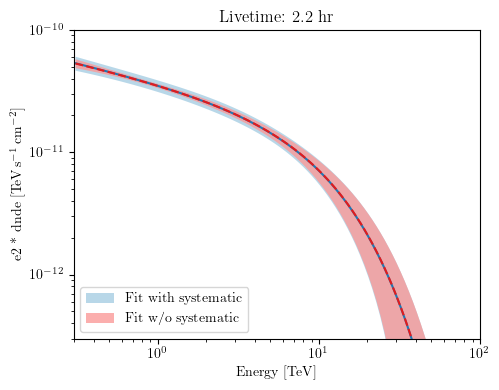

In [12]:
energy_power = 2
energy_bounds = (0.3, 100) *u.TeV
def plot_spectrum(i, ax):
    live = livetimes[i]
    dataset = datasets[i]
    dataset_N = datasets_N[i]

    dataset_N.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                                 color = aw[0], ax = ax)    
    paris = [p.name for p in dataset_N.models[0].spectral_model.parameters.free_parameters]
    dataset_N.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                               facecolor= aw[1], alpha = 0.8, 
                                                 label = f'Fit with systematic')
    dataset.models[0].spectral_model.plot(energy_bounds,energy_power = energy_power, ax = ax, 
                                               color= awo[0], linestyle = 'dashed')

    dataset.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                               facecolor= awo[1], alpha = 0.8,
                                               label = f'Fit w/o systematic')
    ax.set_title(f"Livetime: {float(live):.2} hr")
    ax.set_ylim(3e-13, 1e-10)

    if i <2:
        ax.set_ylim(6e-13, 6e-9)


    if live in lives:
        idx = 0
        #idx = np.where(live == lives)[0]
        fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                             label = "Fluxpoint with \nsystematic and statistic",
                             capsize = 5)
        fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                            label = "Fluxpoint w/o \nsystematic and with statistic",
                            capsize = 5)
    ax.legend(loc = 'lower left')
    plt.tight_layout()
    ax.set_xlim(energy_bounds[0], energy_bounds[1])
    return fig
        
i = 7 
fig,ax = plt.subplots(1, 1, figsize = (5, 4 ))

fig = plot_spectrum(i, ax)
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}.pdf')

In [13]:
def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)

def plot_coverage(fig, ax2):
    p = compute_precision(N)
    ax2.errorbar(ebins, withine, yerr=p, color=awo[0], label="")
    ax2.errorbar(ebins * 1.05, withine_N, yerr=p, color=aw[0], label="")
    ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    # ax2.legend(ncol = 2)
    axs.set_title(f"N = {N} (p = {p*100:.3}\\%)")
    ax2.set_xlabel("Energy [TeV]")
    ax2.set_ylabel("Coverage")
    axs.set_xlabel("")
    plt.tight_layout()

In [14]:
N = len(flux2e)
N

801

In [15]:
mask = dataset_input.mask.data.sum(axis=2).sum(axis=1) > 0
ebins = dataset_input.counts.geom.axes[0].center[mask]
i = 7
asimov, asimov_errors = datasets[i].models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = datasets_N[i].models[0].spectral_model.evaluate_error(
    ebins,
)

withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)
print(withine)
print(withine_N)

[0.4431960049937578, 0.3782771535580524, 0.32209737827715357, 0.2846441947565543, 0.2958801498127341, 0.34207240948813983, 0.38701622971285893, 0.4232209737827715, 0.46441947565543074, 0.4918851435705368, 0.5418227215980025, 0.5792759051186017, 0.6392009987515606, 0.651685393258427, 0.6928838951310862, 0.731585518102372, 0.797752808988764, 0.7677902621722846, 0.7378277153558053, 0.7066167290886392]
[0.6916354556803995, 0.6928838951310862, 0.6928838951310862, 0.6953807740324595, 0.6803995006242197, 0.6841448189762797, 0.6903870162297129, 0.6916354556803995, 0.6666666666666666, 0.6679151061173533, 0.6629213483146067, 0.6666666666666666, 0.6704119850187266, 0.6766541822721598, 0.7016229712858927, 0.7378277153558053, 0.797752808988764, 0.7690387016229713, 0.7378277153558053, 0.7066167290886392]


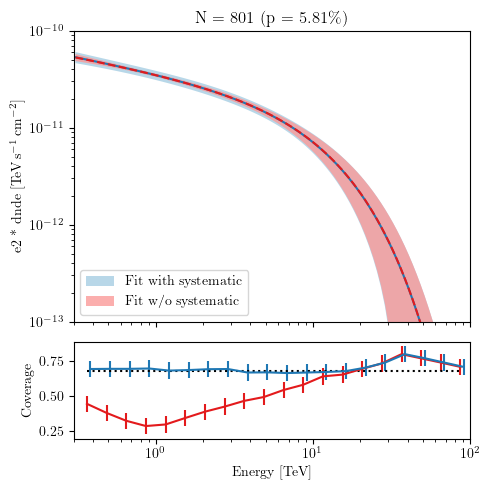

In [16]:
i = 7 
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((5, 5))
)
fig = plot_spectrum(i, axs)



energy_bounds = (0.3, 100) *u.TeV

plot_coverage(fig, ax2)
yy = axs.get_ylim()
#for f in flux2e:
#    axs.plot(ebins, f, color = 'grey', alpha = 0.2)
    
ax2.set_xscale("log")
axs.set_ylim(yy[0], yy[1])
#axs.set_ylim(1e-12, yy[1])
axs.set_ylim(1e-13, yy[1])
axs.set_xlabel("")
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}.pdf')
